In [48]:
import pandas as pd
from pycoingecko import CoinGeckoAPI

# Initialiser le client CoinGeckoAPI
cg = CoinGeckoAPI()

# Paramètres pour la requête API
parameters = {
    'vs_currency': 'usd',
    'order': 'market_cap_desc',
    'per_page': 50,
    'page': 1,
    'sparkline': False,
    'locale': 'en'
}

# Récupérer les données du marché
coin_market_data = cg.get_coins_markets(**parameters)

# Convertir les données en DataFrame
df = pd.DataFrame(coin_market_data)

# Sélectionner les IDs des cryptomonnaies
top_100_coins = df[['id']].head(100)



In [49]:
import pandas as pd
from pycoingecko import CoinGeckoAPI
import os

# Initialiser le client CoinGeckoAPI
cg = CoinGeckoAPI()

# Fonction pour récupérer les données historiques d'une cryptomonnaie
def fetch_historical_data(coin_id, start_date, end_date):
    start_timestamp = int(pd.Timestamp(start_date).timestamp())
    end_timestamp = int(pd.Timestamp(end_date).timestamp())
    historical_data = cg.get_coin_market_chart_range_by_id(id=coin_id, vs_currency='usd',
                                                           from_timestamp=start_timestamp, to_timestamp=end_timestamp)
    prices = historical_data['prices']
    df_historical = pd.DataFrame(prices, columns=['timestamp', 'price'])
    df_historical['timestamp'] = pd.to_datetime(df_historical['timestamp'], unit='ms')
    df_historical.set_index('timestamp', inplace=True)
    return df_historical

# Récupérer les données du marché pour le Top 50 des cryptomonnaies
market_data = cg.get_coins_markets(vs_currency='usd', order='market_cap_desc', per_page=50, page=1)
df_market = pd.DataFrame(market_data)
top_50_coins = df_market.head(50)

# Boucle pour récupérer les données historiques pour chaque cryptomonnaie
historical_dataframes = {}
for index, row in top_50_coins.iterrows():
    coin_id = row['id']
    print(f"Téléchargement des données pour {coin_id}.")
    df_historical = fetch_historical_data(coin_id, '2020-01-01', '2024-03-21')
    historical_dataframes[coin_id] = df_historical

# Créer un dossier pour stocker les fichiers CSV
data_dir = r'C:\Users\MasterPC\VSCODE\Cryptorobot\Backtest-Tools-V2\database\historical_data'
os.makedirs(data_dir, exist_ok=True)

# Enregistrer chaque DataFrame dans un fichier CSV
for coin_id, df_historical in historical_dataframes.items():
    file_path = os.path.join(data_dir, f"{coin_id}_historical_data.csv")
    df_historical.to_csv(file_path)

print("Les données historiques ont été téléchargées et enregistrées avec succès.")

Téléchargement des données pour bitcoin.
Téléchargement des données pour ethereum.
Téléchargement des données pour tether.
Téléchargement des données pour binancecoin.
Téléchargement des données pour solana.
Téléchargement des données pour ripple.
Téléchargement des données pour staked-ether.
Téléchargement des données pour usd-coin.
Téléchargement des données pour cardano.
Téléchargement des données pour dogecoin.
Téléchargement des données pour avalanche-2.
Téléchargement des données pour shiba-inu.
Téléchargement des données pour the-open-network.
Téléchargement des données pour polkadot.
Téléchargement des données pour chainlink.
Téléchargement des données pour tron.
Téléchargement des données pour wrapped-bitcoin.
Téléchargement des données pour matic-network.
Téléchargement des données pour uniswap.
Téléchargement des données pour bitcoin-cash.
Téléchargement des données pour near.
Téléchargement des données pour litecoin.
Téléchargement des données pour internet-computer.
Téléch

In [65]:
import pandas as pd
import os

data_dir = r'C:\Users\MasterPC\VSCODE\Cryptorobot\Backtest-Tools-V2\database\historical_data'

# Dictionnaire pour stocker les DataFrames chargées
historical_dataframes = {}

# Liste des fichiers CSV dans le dossier
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

# Charger les données de chaque fichier CSV
for file in csv_files:
    coin_id = file.replace('_historical_data.csv', '')  # Extraire l'ID de la cryptomonnaie à partir du nom du fichier
    file_path = os.path.join(data_dir, file)
    df = pd.read_csv(file_path, index_col='timestamp', parse_dates=True)
    historical_dataframes[coin_id] = df

print("Les données historiques ont été chargées avec succès à partir des fichiers CSV.")

Les données historiques ont été chargées avec succès à partir des fichiers CSV.


In [66]:
import pandas as pd

def calculate_ema(prices, window):
    """Calculer la moyenne mobile exponentielle."""
    return prices.ewm(span=window, adjust=False).mean()

def calculate_mad_score(ema_short, ema_long):
    """Calculer le score MAD."""
    return ema_short / ema_long



In [67]:
# Initialisation
capital = 1500
portfolio = {}  
portfolio_history = []  
short_window = 21  
long_window = 200  

In [68]:
daily_scores = {} 

for date in pd.date_range(start='2021-01-01', end='2024-03-21'):
    scores = {}
    for coin_id, df in historical_dataframes.items():
        if date in df.index:
            ema_short = calculate_ema(df.loc[:date, 'price'], short_window).iloc[-1]
            ema_long = calculate_ema(df.loc[:date, 'price'], long_window).iloc[-1]
            mad_score = calculate_mad_score(ema_short, ema_long)
            scores[coin_id] = mad_score
    daily_scores[date] = scores

In [69]:
for date, scores in daily_scores.items():
    top_15_coins = sorted(scores, key=scores.get, reverse=True)[:15]

    # Vendre des actifs
    for coin in list(portfolio.keys()):
        if date in historical_dataframes[coin].index:
            current_price = historical_dataframes[coin].loc[date, 'price']
            ema_long = calculate_ema(historical_dataframes[coin].loc[:date, 'price'], long_window).iloc[-1]
            
            if current_price < ema_long or coin not in top_15_coins:
                capital += portfolio[coin] * current_price  # Mise à jour du capital après vente
                del portfolio[coin]  # Suppression du portfolio

    # Calculer l'allocation par actif à acheter
    coins_to_buy = [coin for coin in top_15_coins if coin not in portfolio.keys()]
    if coins_to_buy:
        allocation_per_coin = capital / len(coins_to_buy) if capital > 0 else 0

        # Acheter des actifs
        for coin in coins_to_buy:
            if date in historical_dataframes[coin].index:
                coin_price = historical_dataframes[coin].loc[date, 'price']
                ema_long = calculate_ema(historical_dataframes[coin].loc[:date, 'price'], long_window).iloc[-1]
                
                if coin_price >= ema_long and capital >= allocation_per_coin:
                    quantity_to_buy = allocation_per_coin / coin_price
                    portfolio[coin] = quantity_to_buy  # Mise à jour de la quantité
                    capital -= allocation_per_coin  # Déduction du capital utilisé pour l'achat

    # Mise à jour de la valeur du portfolio
    portfolio_value = sum(historical_dataframes[coin].loc[date, 'price'] * quantity for coin, quantity in portfolio.items() if date in historical_dataframes[coin].index) + capital
    portfolio_history.append((date, portfolio_value))

Capital initial: 1500 $
--- Informations Générales ---
Capital final: 1011588.15 $
Performance: 67339.21 %
Pire drawdown: -86.70 %


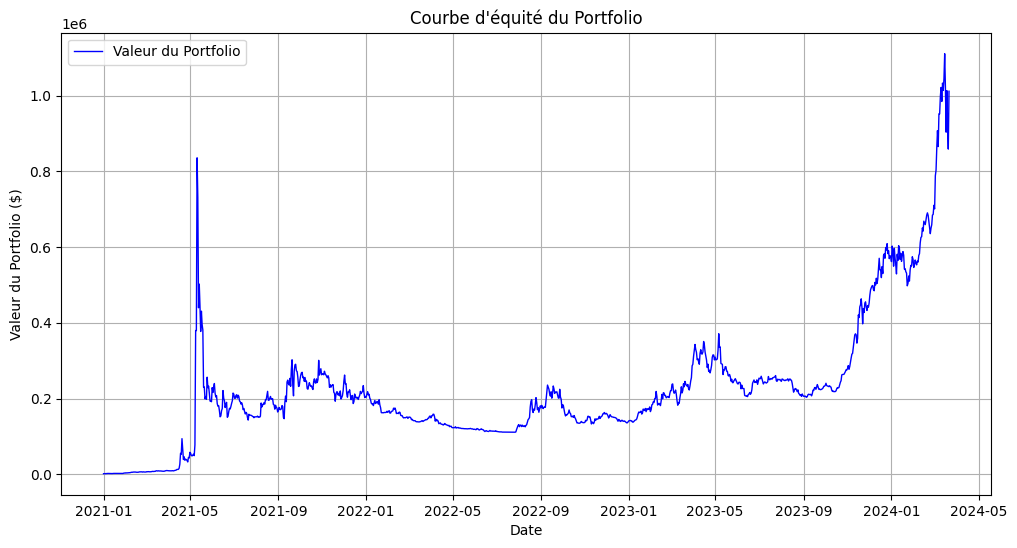

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

df_portfolio_history = pd.DataFrame(portfolio_history, columns=['Date', 'Portfolio Value'])
df_portfolio_history['Date'] = pd.to_datetime(df_portfolio_history['Date'])
df_portfolio_history.set_index('Date', inplace=True)

if not df_portfolio_history.empty:

    # Wallet initial et final 
    initial_wallet = 1500  
    final_wallet = df_portfolio_history['Portfolio Value'].iloc[-1]

    # Performance
    performance = (final_wallet / initial_wallet - 1) * 100

    # Calcul du Drawdown Maximal
    peak_values = df_portfolio_history['Portfolio Value'].cummax()
    drawdowns = (df_portfolio_history['Portfolio Value'] - peak_values) / peak_values
    worst_drawdown = drawdowns.min() * 100

    # Affichage des résultats
    
    print(f"Capital initial: {initial_wallet} $")
    print("--- Informations Générales ---")
    print(f"Capital final: {final_wallet:.2f} $")
    print(f"Performance: {performance:.2f} %")
    print(f"Pire drawdown: {worst_drawdown:.2f} %")
    
    # Chart
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_portfolio_history.index, df_portfolio_history['Portfolio Value'], label='Valeur du Portfolio', color='blue', linewidth=1)
    plt.title('Courbe d\'équité du Portfolio')
    plt.xlabel('Date')
    plt.ylabel('Valeur du Portfolio ($)')

    # Utilisation de ScalarFormatter pour forcer le formatage en nombres entiers
    ax = plt.gca()  # Obtient l'axe actuel
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Le DataFrame est vide. Assurez-vous que `portfolio_history` contient des données avant de continuer.")

